In [1]:
import random
import time
from tqdm import tqdm

import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

from gensim.models import Word2Vec, KeyedVectors
import nltk

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

C:\Users\lenovo2019\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#CHROME OPTIONS 
chrome_options = Options()
#chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-popup-blocking")
chrome_options.add_argument("--disable-notifications")
chrome_options.add_argument("--ignore-certificate-errors")

In [3]:
class ScrapApp():
    def randDelay(self, a, b):
        time.sleep(random.uniform(a, b))
        
    def runDriver(self):
        self.driver = webdriver.Chrome(options=chrome_options)
        return "Driver has been started successfully!"

    def getReport(self,platform):
        with open('report'+platform+'.txt', 'w') as f:
            for item in report:
                f.write("%s\n" % item)

    def getNewsLinks(self, tag_url_list):
        news_link_set = set()
        for tag_url in tag_url_list:
            self.driver.get(tag_url)
            self.randDelay(4,5)
            for x in range(3):
                try:
                    title_list = self.driver.find_elements_by_class_name('entry-title')
                    for post in title_list:
                        link_element = post.find_element_by_tag_name('a')
                        link_text = link_element.get_attribute('href')
                        news_link_set.add(link_text)
                    next_button = self.driver.find_element_by_class_name('herald-next')
                    next_button.click()
                    self.randDelay(4,5) 
                except:
                    print(tag_url + " passed!")
        return news_link_set
    
    def getPostContent(self, news_links):
        df_post_data = pd.DataFrame()
        for post in tqdm(news_links):
            #post, entry_title, free_text, entry_date
            self.driver.get(post)
            self.randDelay(1,2)
            entry_date = self.driver.find_element_by_class_name('herald-date').text
            entry_title = self.driver.find_element_by_class_name('entry-title').text
            entry_content = self.driver.find_element_by_class_name('herald-entry-content').text.split("Arkadaşlarınla paylaş:")
            content_text = entry_content[0]
            split_text = content_text.split('\n')
            free_text = ''.join([x + ' ' for x in split_text])
            df_post_data = df_post_data.append([[post, entry_title, free_text, entry_date]])
        return df_post_data

In [4]:
#1 DunyaHalleri.com'dan Verinin Çekilmesi
#kategoriler sabit olduğu için kategorileri otomatize etmedim, her kategoriden ortalama bir haber içeriği almak istiyorum.
tag_list = [
    'https://www.dunyahalleri.com/tag/yapay-zeka,otomasyon,machine-learning,makine-ogrenimi/',
    'https://www.dunyahalleri.com/tag/robot/',
    'https://www.dunyahalleri.com/tag/buyuk-veri,big-data/',
    'https://www.dunyahalleri.com/tag/vr,ar,artirilmis-gerceklik,sanal-gerceklik/',
    'https://www.dunyahalleri.com/tag/kripto-para,bitcoin,dijital-para/',
    'https://www.dunyahalleri.com/tag/saglik,dijital-saglik/',
    'https://www.dunyahalleri.com/tag/3d-yazici,3d-printer/',
    'https://www.dunyahalleri.com/tag/otomotiv/',
    'https://www.dunyahalleri.com/tag/uzay/',
    'https://www.dunyahalleri.com/tag/finans-teknolojileri,fintek,fintech/'
]

In [5]:
app = ScrapApp()

In [6]:
app.runDriver()

'Driver has been started successfully!'

In [7]:
news_links = app.getNewsLinks(tag_list)

https://www.dunyahalleri.com/tag/buyuk-veri,big-data/ passed!
https://www.dunyahalleri.com/tag/buyuk-veri,big-data/ passed!
https://www.dunyahalleri.com/tag/finans-teknolojileri,fintek,fintech/ passed!
https://www.dunyahalleri.com/tag/finans-teknolojileri,fintek,fintech/ passed!


In [8]:
len(news_links)

438

In [9]:
df = app.getPostContent(news_links)

100%|██████████| 438/438 [24:01<00:00,  3.43s/it]


In [11]:
app.driver.quit()

In [12]:
df.columns = ['link','title', 'content', 'date']
df = df.reset_index(drop=True)

In [13]:
df.head()

,link,title,content,date
0,https://www.dunyahalleri.com/mitnin-parende-at...,MIT’nin parende atan robotu,MIT'nin geliştirdiği şirin robot Mini Cheetah ...,02/03/2019
1,https://www.dunyahalleri.com/hindistan-aya-iki...,Hindistan Ay’a ikinci uzay aracını gönderiyor,"Hindistan, geçtiğimiz Çarşamba yapılan bir açı...",15/06/2019
2,https://www.dunyahalleri.com/spotmininin-artik...,SpotMini’nin artık kolları da var,"Youbionic adlı İtalyan şirket, yeni geliştirdi...",28/11/2018
3,https://www.dunyahalleri.com/microsoft-worde-y...,Microsoft Word’e yapay zeka desteği geliyor,"Microsoft Word, Ideas adlı yeni özellik sayesi...",07/05/2019
4,https://www.dunyahalleri.com/yapay-zeka-islevi...,"Yapay zeka, işlevini kaybedecek böbreği iki gü...","DeepMind adlı yapay zeka şirketi, akut böbrek ...",01/08/2019


In [14]:
df.shape

(438, 4)

In [15]:
df.isnull().sum()

link       0
title      0
content    0
date       0
dtype: int64

In [16]:
#save as excel sheet from dataframe
df.to_excel('news_content.xlsx')

In [17]:
#3 Word2Vec ve #4 verilen 5 kelimenin raporlanması

def getW2VModel(df):
    content_all = df['content'].values
    content_vec = [nltk.word_tokenize(content.lower()) for content in content_all]
    for post in content_vec:
        for word in post:
            if word.isalpha() == False:
                post.remove(word)

    model = Word2Vec(content_vec, min_count=1,window=5, workers=10, iter=10)
    
    word_list = ['dünya', 'teknoloji','yapay', 'zeka','robotik']
    df_similar_words = pd.DataFrame()
    for word in word_list:
        result = model.wv.most_similar(positive=word, topn=5)
        top5_words = list()
        for w,s in result:
            top5_words.append(w)
        df_similar_words = df_similar_words.append([[word,top5_words]])
        df_similar_words = df_similar_words.reset_index(drop=True)       
    return df_similar_words, model

In [18]:
df_similar_words,model = getW2VModel(df)
df_similar_words.columns = ['konu basliklari' , 'W2Vec Sonuçları']

In [19]:
df_similar_words

,konu basliklari,W2Vec Sonuçları
0,dünya,"[denk, u, lokma, benzin, üreme]"
1,teknoloji,"[kurgu, bilim, alexa, gelişmeler, ulsan]"
2,yapay,"[merhamet, gerileme, soluyan, alışkanlıkların,..."
3,zeka,"[zekadan, zekayı, zekanın, zekayla, deriyi]"
4,robotik,"[geliştirdiği, adında, üniversitesinde, q, düş..."


In [20]:
#2 Model Verinin Görselleştirmesi
vocab = list(model.wv.vocab)
X = model.wv[vocab]

print(len(vocab))
print(len(X))

31463
31463


In [21]:
#fit transform for visualization
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

print(X.shape)
print(X_tsne.shape)

df_visual = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

(31463, 100)
(31463, 2)


In [22]:
#see x,y values of words
df_visual.head()

,x,y
geliştirdiği,-8.431002,58.232185
şirin,51.039948,14.369407
robot,-33.439671,43.196564
mini,-7.317189,57.255039
cheetah,32.467350,-46.322132


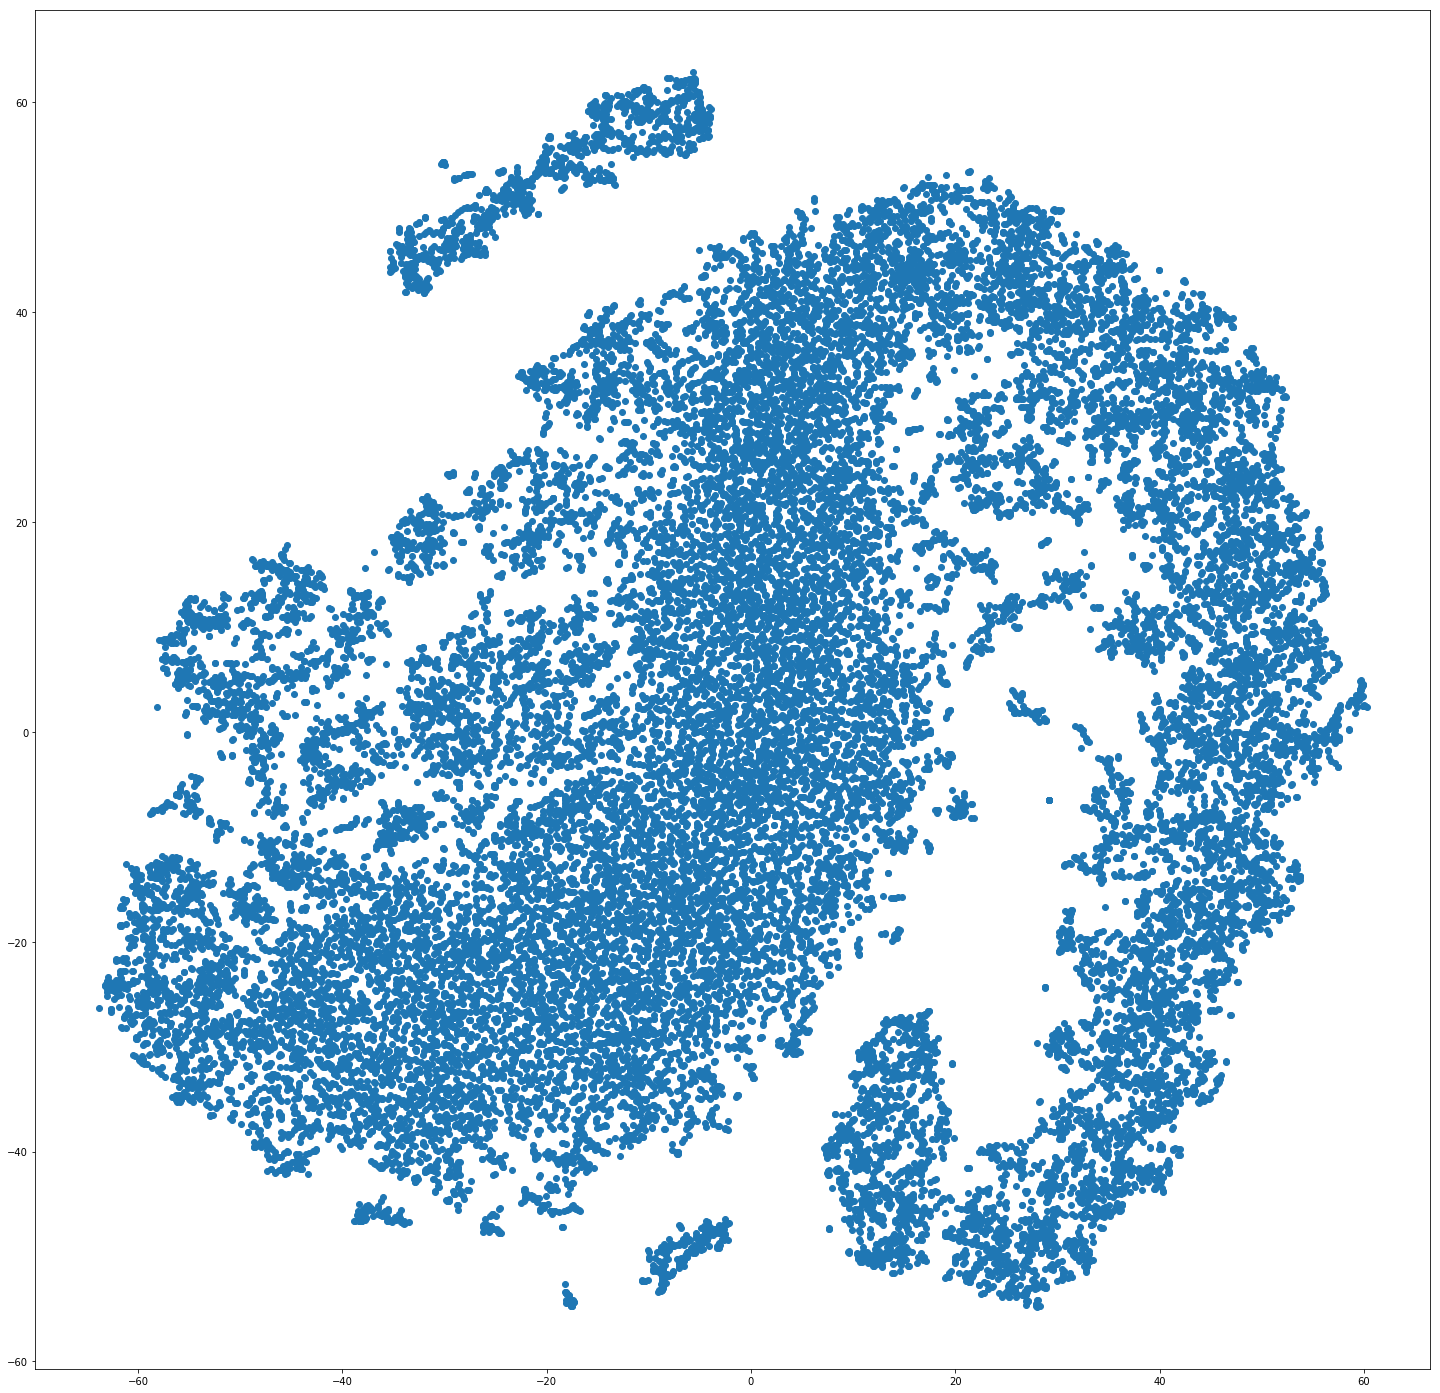

In [26]:
#scatterplot
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_visual['x'], df_visual['y'])

In [27]:
#vectoral representation of words related each other
for word, pos in df_visual.iterrows():
    ax.annotate(word, pos)

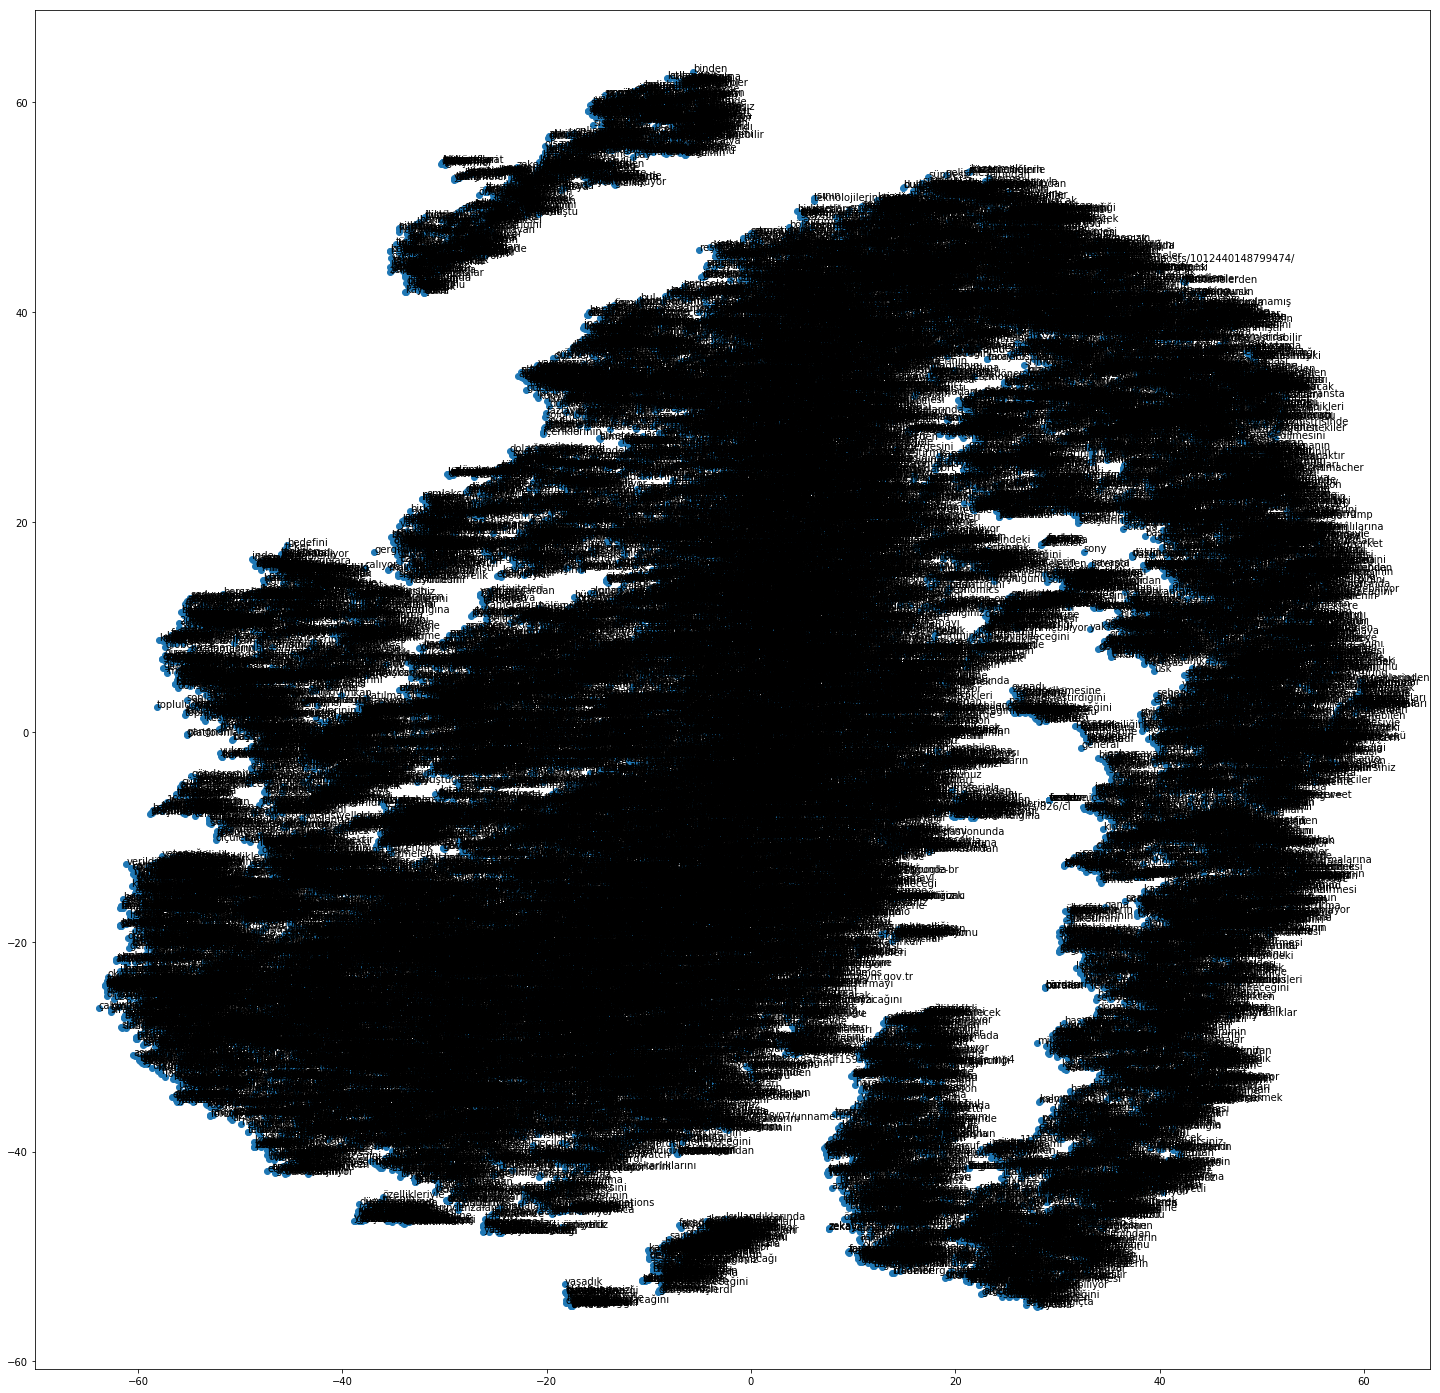

In [28]:
fig